In [1]:
# The first thing looks like it keeps the data from doing integer division
# which we don't really need to worry about since Python 3.0 already does this
# for us. 
from __future__ import division
import hoomd
import hoomd.md
import numpy as np

In [2]:
# This initializes will parse command line arguments and will initialize
# GPU execution if that was defined. 

# You can call this more than once in a script but execution parameters
# are fixed on the first call of it. 
hoomd.context.initialize("");

HOOMD-blue 2.3.1 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
#This will create a simple lattice of the center of mass particles.
#These particles define the mass and moment of inertia of the rigid body. 
#Will create the center of mass particles of type R.

# Variables in the "method":
    # N is the number of particles in the unit cell
    # a1, a2, and a3 are all lattice vectors that create a box
    # dimensions tells us if it is 2D or 3D (default is 3)
    # position is a list that contains particle positions. Since we only have 
        # the center particle, there is only one in our list
    # type_name is the name of the particle types in our unitcell
    # mass is a list that contains the particle masses
    # moment_inertia is a list of the moments of inertia of the particles - diagonal (vectors 
        # always have 3 components)
    # orientation is the list of particle orientations - will always be [1,0,0,0]
# The mass and moment of this particle will describe how the rigid body works as a whole. 

uc = hoomd.lattice.unitcell(N = 1,
                           a1 = [5, 0, 0],
                           a2 = [0, 5, 0],
                           a3 = [0, 0, 0],
                           dimensions = 2,
                           position = [[0,0,0]],
                           type_name = ['_R0'],
                           mass = [15.0], 
                           moment_inertia = [[60.83333333, 
                                              812.5, 
                                              873.33333333]],
                           orientation = [[1,0,0,0]]);

# This will create a lattice using the above unitcell and replicate it in the
# x,y, and z directions the number of times specified in the list called n

# We named our whole "cell" system so that we can access it later. 

system = hoomd.init.create_lattice(unitcell=uc, n = [5,5]);

notice(2): Group "all" created containing 25 particles


/Users/Rachel/VIP_Stuff/miniconda3/lib/python3.5/site-packages/hoomd/lattice.py:94: RuntimeWarning: invalid value encountered in double_scalars
  xz = a3x / Lz
/Users/Rachel/VIP_Stuff/miniconda3/lib/python3.5/site-packages/hoomd/lattice.py:95: RuntimeWarning: invalid value encountered in double_scalars
  yz = (numpy.dot(a2, a3) - a2x*a3x) / (Ly*Lz)


In [4]:
#Adds the particle type for the constituent particles. Constituents 
#can not share a type with any rigid central particle.

#This doesn't actually put anything in the structure. It just says that 
#we will be adding particles of type A coming up

system.particles.types.add('Z');
system.particles.types.add('O')

2

In [5]:
particle_positions = [(7.5, -2.16666675,0.0), (-2.5,-2.16666675,0.0), (-12.5,-2.16666675,0.0), 
                          (2.5,-2.16666675,0.0), (-7.5,-2.16666675,0.0), (12.5,-2.16666675,0.0), 
                          (10.0,0.33333325,0.0), (7.5,2.83333325,0.0), (5.0,0.33333325, 0.0), 
                          (0.0,0.33333325, 0.0), (-5.0,0.33333325,0.0), (-10.0,0.33333325,0.0), 
                          (2.5,2.83333325, 0.0), (-2.5,2.83333325,0.0), (-7.5,2.83333325,0.0)]
particle_positions = np.array(particle_positions)
particle_positions /= 10

In [6]:
#Define each rigid body type.

# This line of code creates the idea for a "rigid body" but nothing exists in it yet 
# since nothing has been specified. 
rigid = hoomd.md.constrain.rigid();

# Now we specify what our rigid body is going to look like/include
# This includes specifying our central particle (R), our constituent particle types (A) 
# and how many of them and what positions those constituent particles will be at realtive
# to the central particle which is at (0,0,0)
rigid.set_param('_R0',
               #I think this is making the ideal line segment length equal to 8. 
               types=['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O'],
               #Sets positions of constituent particles 
               positions=particle_positions)


"The positions of the partciles in the local reference frame must be such that the moment of inertia tensor is diagonal. The actual values specified need not assume anything about the body, such as point particles."

"This example is creating rods that are 9 particles long."

In [7]:
#Instructs the rigid constraint to create the constituent particles
#This line actually creates the rigid bodies with the constituent particles specified above.
rigid.create_bodies()
#Now the rods are complete!

notice(2): constrain.rigid(): Creating 25 rigid bodies (adding 375 particles)


In [8]:
#"The WCA potential hsa the same functional form as Lennard-Jones,
#but r_cut = 2^(1/6)*sigma and is shifted up to 0 at the cutoff."

#Specifies the neighborlist acceleration structureto find neighboring
#particles efficiently by using the cell method. 

# EXPLANATION CAN BE FOUND IN LENNARD-JONES CODE

nl = hoomd.md.nlist.cell()

In [9]:
#Defining the functional form of the pair interaction and evaluating using
#the given neighbor list acceleration structure.

# This r_cut value is the distance with the lowest potential energy (the trough)
# EXPLANATION CAN BE FOUND IN LENNARD-JONES CODE
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)

#"A constant shift is applied to the entire potential so that it is 0 at the cutoff"
# You can also do 'xplor' as well which is a gradual decrease in force and potential
lj.set_params(mode='xplor')

** = ^ = exponent

In [10]:
#Specifying pair potential parameters for every pair type. When you put them as two 
#lists, it does all of the combinations
#R and A exist in the system for the rigid bodies but both should interact identically.
#The R particle is in the center of the rod.

# EXPLANATION CAN BE FOUND IN LENNARD-JONES CODE

lj.pair_coeff.set(['O', 'Z', '_R0'], ['O', 'Z', '_R0'], epsilon=1, sigma=1.0, alpha=0)
lj.pair_coeff.set(['_R0'], ['O', 'Z', '_R0'], epsilon=0, sigma=0)
lj.pair_coeff.set('O', 'O', epsilon=1.0, sigma=1.0);

# NOW GOING TO SELECT AN INTEGRATOR

In [11]:
# EXPLANATION CAN BE FOUND IN LENNARD-JONES CODE
hoomd.md.integrate.mode_standard(dt=0.005);

In [12]:
# This line groups particles that are the centers of rigid bodies (in our case that would be all R particles)
# Why are we naming it the same thing as above?
rigid = hoomd.group.rigid_center();

# We now apply the langevin forces to only the rigid centers since they will act as the whole rigid body
# We don't necessariy care about the individual parameters of the constituent particles. 
# If there were non-rigid particles, we would have to apply an integrator to them as well. 
integrate = hoomd.md.integrate.langevin(group=rigid, kT=0.1, seed=42);

notice(2): Group "rigid_center" created containing 25 particles
notice(2): integrate.langevin/bd is using specified gamma values


The code beyond this point is routine and self-explained. There might be more in-depth 
explanations of it in the Lennard Jones simulation example but it really isn't needed since
we are only dealing with graphs and output files.

In [13]:
hoomd.analyze.log(filename="Rigid_Trap_Output.log",
                 quantities=['potential_energy',
                            'translational_kinetic_energy',
                            'rotational_kinetic_energy'],
                 period=100,
                 overwrite=True);

In [14]:
hoomd.dump.gsd("Rigid_Trap_Trajectory.gsd",
              period=2e3,
              group=hoomd.group.all(),
              overwrite=True);

In [15]:
hoomd.run(1e6)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 400
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 176381 / 1000000 | TPS 17638 | ETA 00:00:46
Time 00:00:20 | Step 342836 / 1000000 | TPS 16645.4 | ETA 00:00:39
Time 00:00:30 | Step 516340 / 1000000 | TPS 17350.4 | ETA 00:00:27
Time 00:00:40 | Step 694945 / 1000000 | TPS 17860.5 | ETA 00:00:17
Time 00:00:50 | Step 885447 / 1000000 | TPS 19050.2 | ETA 00:00:06
Time 00:00:56 | Step 1000000 / 1000000 | TPS 19100 | ETA 00:00:00
Average TPS: 17857.3
---------
-- Neighborlist stats:
2 normal updates / 10000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 3 / n_neigh_avg: 0.0575
shortest rebuild period: 97
-- Cell list stats:
Dimension: 16, 16, 1
n_min    : 0 / n_max: 13 / n_avg: 1.5625
** run complete **


In [16]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='Rigid_Trap_Output.log', skip_header=True)

Text(0,0.5,'potential_energy')

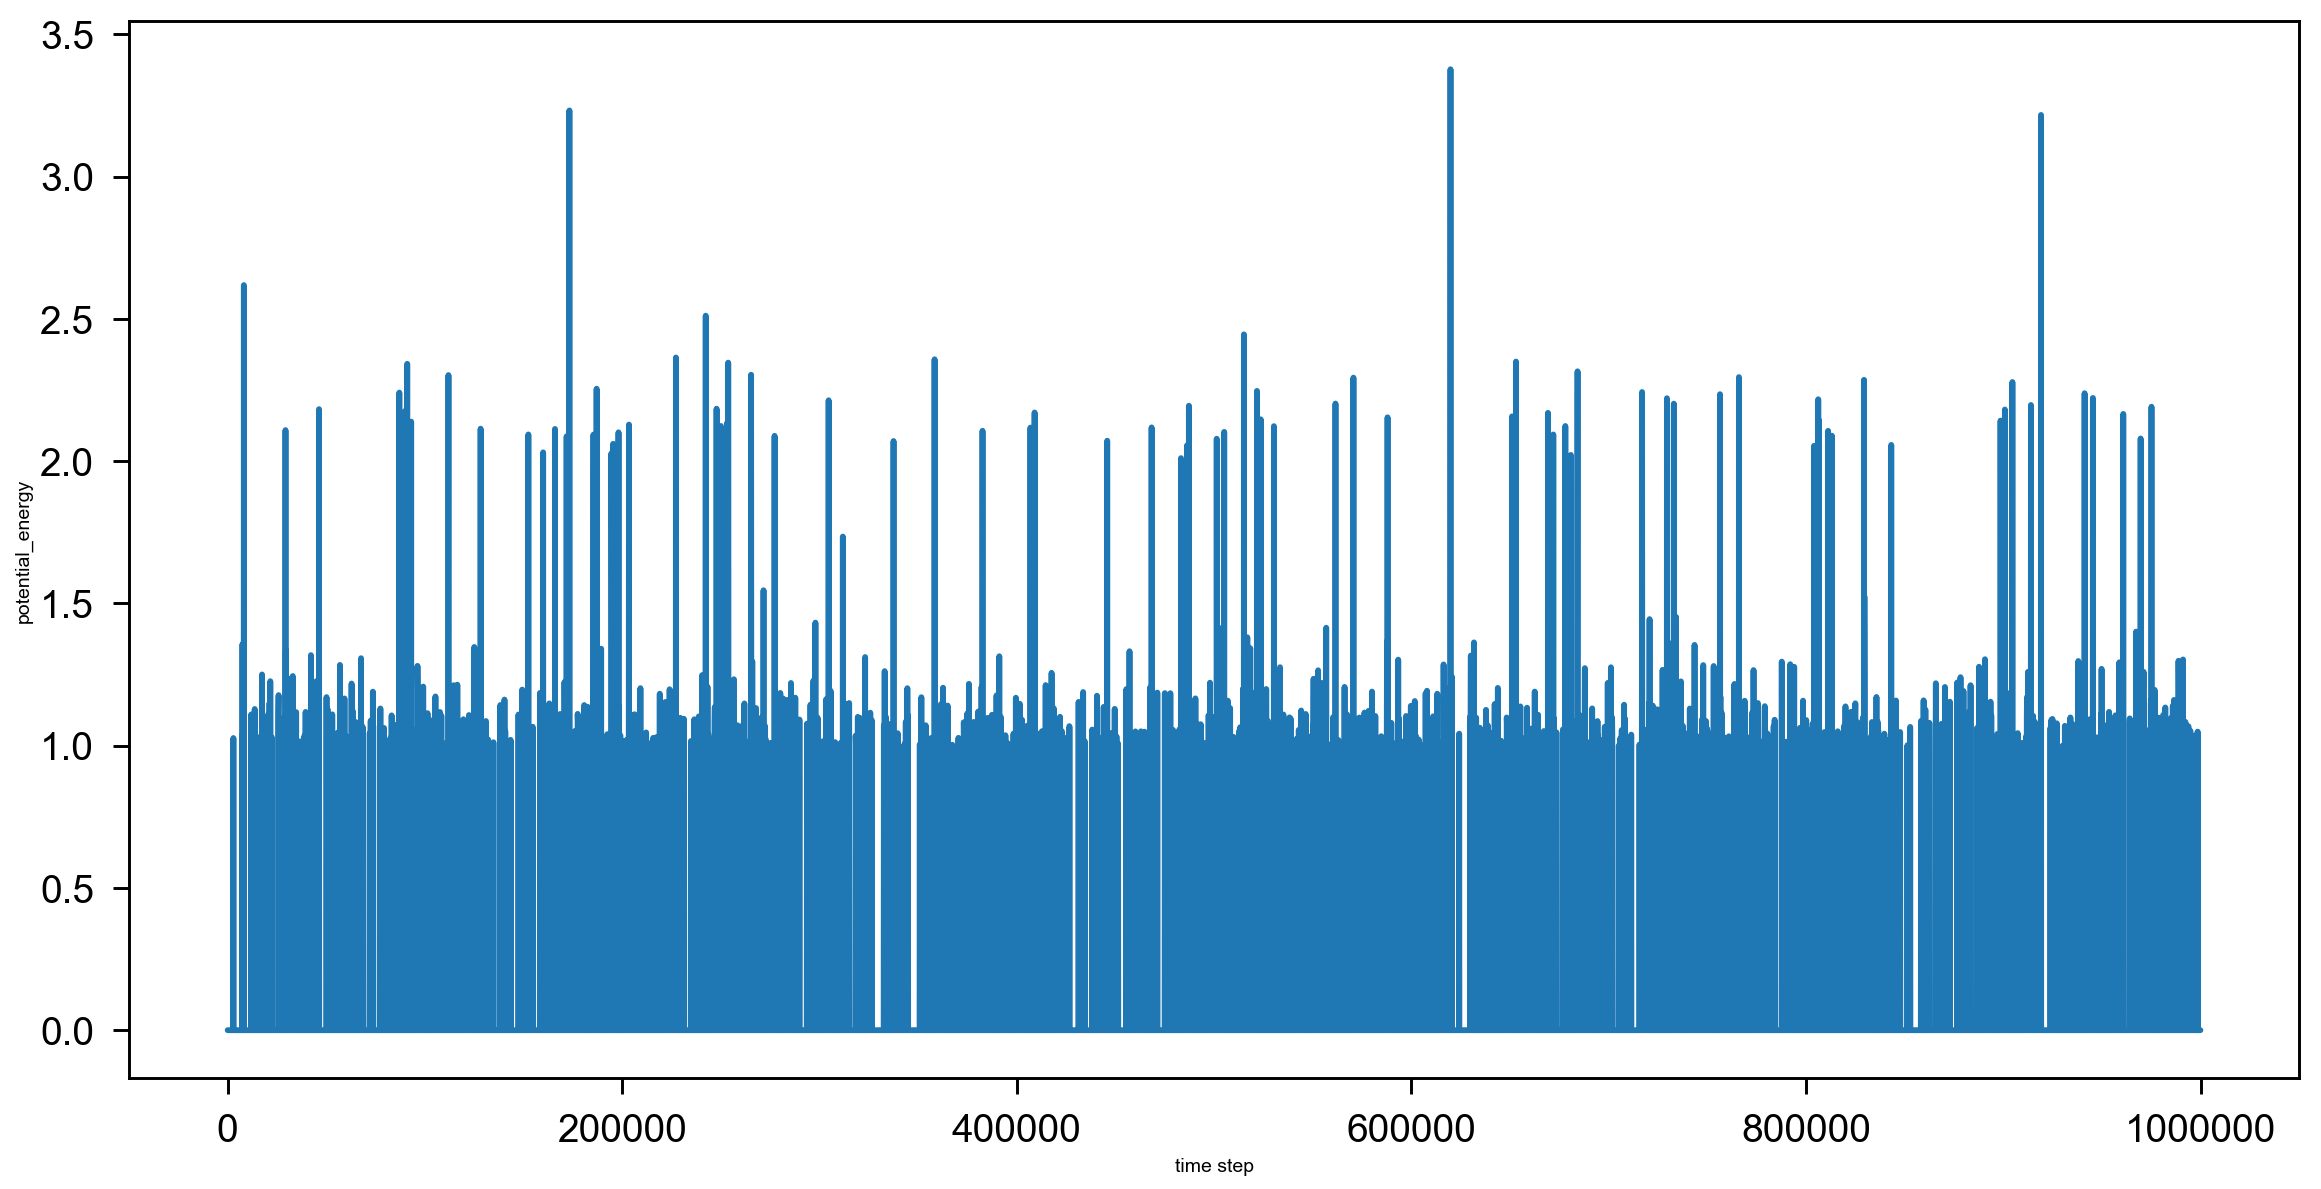

In [17]:
pyplot.figure(figsize=(20,10), dpi=140)
pyplot.plot(data[:,0], data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('potential_energy')

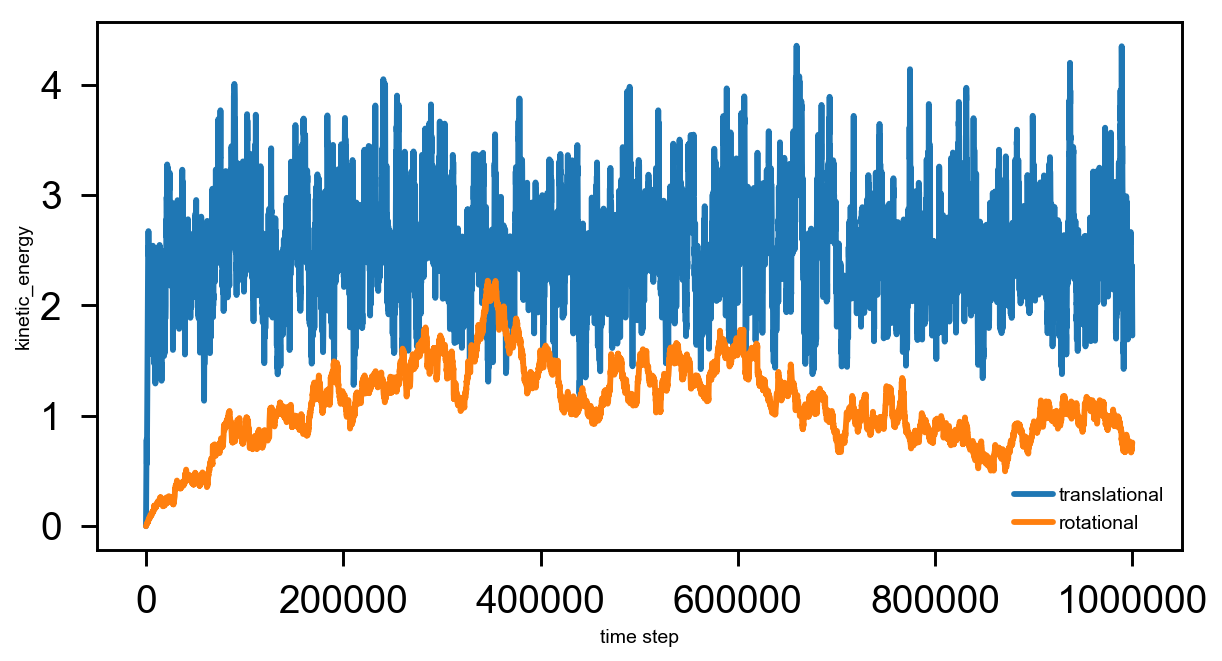

In [18]:
pyplot.figure(figsize=(10,5), dpi=140)
pyplot.plot(data[:,0], data[:,2])
pyplot.plot(data[:,0], data[:,3])
pyplot.xlabel('time step')
pyplot.ylabel('kinetic_energy')
pyplot.legend(['translational', 'rotational'], loc='lower right')